### [1]

### Importing the libraries:

In [1]:
import pandas as pd
import numpy as np
import shutup 
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, plot_roc_curve, plot_precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
shutup.please()

##### Description:

As a standard, I am importing the pandas, numpy, and shutup libraries which are required for my computation purposes. 

Importing all the classifiers and the metric systems that are used to fit the training set, predict and plot the results using curves
##### Techniques used for Hyperparameter searching and fitting the models: 
    
    sklearn Pipeline
    sklearn GridSearchCV
    sklearn ColumnTransformer
    sklearn StandardScaler

##### Models :
    Decision Tree
    Logistic Regression
    RandomForest
    XGBoost

### [2]

### Reading the file:

In [2]:
new_df = pd.read_pickle("./final")

##### Description:

As opposed to using a json file everytime and storing the csv file is going to take a lot of space, the data is pickled into a mediocre size as opposed to almost 600MB of the entire JSON file.

##### Reading and storing the dataset:

Using the inbuilt function of reading pickle, I imported teh Dataset.

### [3] 

### Cleaning and preparing the data to train:

#### [3.1]

Splitting the X and Y parts of the data where Y is the variable to predict i.e. isFraud and X is rest others

In [3]:
X = new_df.drop("isFraud", 1)
Y = new_df.isFraud

#### [3.2]

Preserving the accountNumber as it might be useful in future.

(Spoiler Alert: It is not useful)

In [5]:
accountNumber = X['accountNumber']
X.drop('accountNumber', axis = 1, inplace = True)

In [6]:
X["creditLimit"].dtype

dtype('int64')

#### [3.3]

#### Record classification

**Method:** 
    
Classifying the variables into boolean, categorical and numeric.

Numeric: The records which are neither boolean or object type

Boolean: The record which are boolean type

Categorical: The records which are object type

In [7]:
numeric = []
for column in X.columns.to_list():
    if(X[column].dtype != object and X[column].dtype!=bool):
        numeric.append(column)

In [8]:
numeric

['creditLimit',
 'availableMoney',
 'transactionAmount',
 'currentBalance',
 'multiswipeMinutes']

In [9]:
boolean_col = []
for column in X.columns.to_list():
    if(X[column].dtype == bool):
        boolean_col.append(column)

In [10]:
boolean_col

['cardPresent',
 'expirationDateKeyInMatch',
 'CVV Match',
 'FirstVendorPurchase',
 'sameCountry']

#### [3.4] 

#### Conversion

Converting the boolean to 0,1 as opposed to False, True. 

Since Y is also in boolean format, we are converting it into 0,1 as well

In [11]:
for column in boolean_col:
    X[column] = X[column].replace({False:0, True:1})

In [12]:
Y = Y.replace({False:0, True:1})

In [13]:
Y.value_counts()

0    773946
1     12417
Name: isFraud, dtype: int64

In [14]:
object_col = []
for column in X.columns.to_list():
    if(X[column].dtype == object):
        object_col.append(column)

#### [3.5]

#### One-Hot Encoding

##### Description:

Using the pandas get_dummies method to use the one-hot encoding method. 

##### Suggestion: 
This step can be avoided using the Scikit-learn Pipeline and the ColumnTransformer which can create one-hot encoding at the run-time as opposed to storing in the dataset

##### Input Variables:

The categorical columns along with the dataset.

##### Output variables:

The dataset with the dummy variables:


In [15]:
X_dummies = pd.get_dummies(X, columns = ["posEntryMode", "posConditionCode", "merchantCategoryCode", "transactionType"])

In [16]:
X_dummies.head()

,creditLimit,availableMoney,transactionAmount,currentBalance,cardPresent,expirationDateKeyInMatch,CVV Match,multiswipeMinutes,FirstVendorPurchase,sameCountry,...,merchantCategoryCode_online_retail,merchantCategoryCode_online_subscriptions,merchantCategoryCode_personal care,merchantCategoryCode_rideshare,merchantCategoryCode_subscriptions,transactionType_ADDRESS_VERIFICATION,transactionType_MULTISWIPE,transactionType_PURCHASE,transactionType_REVERSAL,transactionType_UNKNOWN
0,5000,5000.0,98.55,0.0,0,0,1,0.000000,1,1,...,0,0,0,1,0,0,0,1,0,0
1,5000,5000.0,74.51,0.0,1,0,1,84398.366667,1,1,...,0,0,0,0,0,0,0,1,0,0
2,5000,5000.0,7.47,0.0,0,0,1,40572.750000,1,1,...,0,0,0,0,0,0,0,1,0,0
3,5000,5000.0,7.47,0.0,0,0,1,45656.183333,0,1,...,0,0,0,0,0,0,0,1,0,0
4,5000,5000.0,71.18,0.0,1,0,1,0.000000,1,1,...,0,0,0,0,0,0,0,1,0,0


#### [3.6]

#### Column Transformer:

Using StandardScaler to passthrough only the numeric columns for the standard scaling.

In [17]:
ct = ColumnTransformer([
        ('St_Scaler', StandardScaler(), numeric)
    ], remainder='passthrough')

### [4]

### Modelling

##### This part discusses the models that are used throughout the training and testing process. The justification for the models is given after this section.

#### [4.1]
#### DECISION TREE

#### Decision Tree Inputs

##### Description:

Creating a sklearn pipeline using the ColumnTransformer and the DecisionTreeClassifier and pass through all the variable

##### Parameters for Classifier: 

Criterion on which the Tree is trained:
    
    Gini
    Entropy

Max Depth of the tree:
    
    3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
    
##### Inputs:

For the training of the data:
    X_resample and Y_resample:
        
##### Resampling of Data:

Why are we resampling the data?
    
    Before resampling the data, I tried creating a classifer which resulted in 96% accuracy although, bad class 1 accuracy. Hence we undersampled the data so that the classifier can properly identify the features and train it easily
        

In [18]:
decisionTree_pipe = Pipeline(
    steps = [("Transformer", ct), ("Classifier", DecisionTreeClassifier())])

In [19]:
sampler = RandomUnderSampler()
X_sample, Y_sample = sampler.fit_resample(X_dummies, Y)

In [20]:
params = {'Classifier__criterion':['gini', 'entropy'],'Classifier__max_depth':np.arange(3, 20)}

In [21]:
grid_dt = GridSearchCV(decisionTree_pipe,
                      param_grid=params,
                      scoring = 'accuracy', 
                      cv = 5)

In [22]:
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X_sample, Y_sample, test_size = 0.4, random_state = 42, stratify=Y_sample)

In [23]:
grid_dt.fit(X_tr, Y_tr)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('St_Scaler',
                                                                         StandardScaler(),
                                                                         ['creditLimit',
                                                                          'availableMoney',
                                                                          'transactionAmount',
                                                                          'currentBalance',
                                                                          'multiswipeMinutes'])])),
                                       ('Classifier',
                                        DecisionTreeClassifier())]),
             param_grid={'Classifier__criterion': ['gini', 'entropy'],
    

In [24]:
pred = grid_dt.predict(X_ts)

#### Decison Tree Outputs:

##### Metrics:

Precision of class 0, 1, and combined using the classification report

Recall of class 0, 1, and combined using the classification report

F-1 Score of class 0, 1, and combined using the classification report

Accuracy of the model using the classification report

##### Graphs:

Here we have a ROC-Curve that shows how well the model is being fitted to the data.


In [25]:
print(accuracy_score(pred, Y_ts))
print(confusion_matrix(pred, Y_ts))
print(classification_report(pred, Y_ts))

0.6769679887255888
[[3490 1732]
 [1477 3235]]
              precision    recall  f1-score   support

           0       0.70      0.67      0.69      5222
           1       0.65      0.69      0.67      4712

    accuracy                           0.68      9934
   macro avg       0.68      0.68      0.68      9934
weighted avg       0.68      0.68      0.68      9934



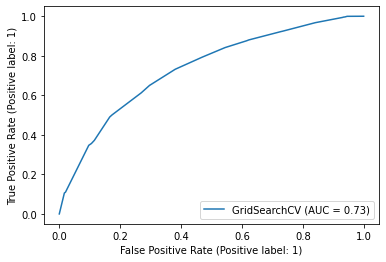

In [26]:
plot_roc_curve(grid_dt, X_ts, Y_ts)

#### [4.2]
#### LOGISTIC REGRESSION 

#### Logistic Regression Inputs

##### Description:

Creating a sklearn pipeline using the ColumnTransformer and the Logistic Regression and pass through all the variable

##### Parameters for Classifier: 

Penalty on which the model is trained:
    
    L1: Ridge
    L2: Lasso

Complexity Penalty of the regressor:
    
    0.001,0.01,0.1,1,10,100,1000
    
##### Inputs:

For the training of the data:
    X_resample and Y_resample:
        
##### Resampling of Data:

Why are we resampling the data?
    
    Before resampling the data, I tried creating a classifer which resulted in 96% accuracy although, bad class 1 accuracy. Hence we undersampled the data so that the classifier can properly identify the features and train it easily
        

In [27]:
logit_pipe = Pipeline(
    steps = [("Transformer", ct), ("Classifier", LogisticRegression())])

In [28]:
sampler = RandomUnderSampler()
X_sample, Y_sample = sampler.fit_resample(X_dummies, Y)

In [29]:
params = {'Classifier__penalty': ['l1','l2'], 'Classifier__C': [0.001,0.01,0.1,1,10,100,1000]}

In [30]:
grid_lr = GridSearchCV(logit_pipe,
                      param_grid=params,
                      scoring = 'accuracy', 
                      cv = 5)

In [31]:
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X_sample, Y_sample, test_size = 0.4, random_state = 42, stratify=Y_sample)

In [32]:
grid_lr.fit(X_tr, Y_tr)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('St_Scaler',
                                                                         StandardScaler(),
                                                                         ['creditLimit',
                                                                          'availableMoney',
                                                                          'transactionAmount',
                                                                          'currentBalance',
                                                                          'multiswipeMinutes'])])),
                                       ('Classifier', LogisticRegression())]),
             param_grid={'Classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'Classifier__p

In [33]:
pred = grid_lr.predict(X_ts)

#### Logistic Regression Outputs:

##### Metrics:

Precision of class 0, 1, and combined using the classification report

Recall of class 0, 1, and combined using the classification report

F-1 Score of class 0, 1, and combined using the classification report

Accuracy of the model using the classification report

##### Graphs:

Here we have a ROC-Curve that shows how well the model is being fitted to the data.


In [34]:
print(accuracy_score(pred, Y_ts))
print(confusion_matrix(pred, Y_ts))
print(classification_report(pred, Y_ts))

0.6806925709683914
[[3266 1471]
 [1701 3496]]
              precision    recall  f1-score   support

           0       0.66      0.69      0.67      4737
           1       0.70      0.67      0.69      5197

    accuracy                           0.68      9934
   macro avg       0.68      0.68      0.68      9934
weighted avg       0.68      0.68      0.68      9934



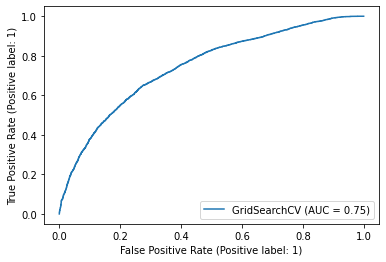

In [35]:
plot_roc_curve(grid_lr, X_ts, Y_ts)

#### [4.3]
#### RANDOM FOREST

#### Random Forest Inputs

##### Description:

Creating a sklearn pipeline using the ColumnTransformer and the RandomForestClassifier and pass through all the variable

##### Parameters for Classifier: 

Criterion on which randomForest is trained:
    
    Gini
    Entropy

Max Depth of the tree:
    
    3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
    
##### Inputs:

For the training of the data:
    X_resample and Y_resample:
        
##### Resampling of Data:

Why are we resampling the data?
    
    Before resampling the data, I tried creating a classifer which resulted in 96% accuracy although, bad class 1 accuracy. Hence we undersampled the data so that the classifier can properly identify the features and train it easily
        

In [36]:
RandomForest_pipe = Pipeline(
    steps = [("Transformer", ct), ("Classifier", RandomForestClassifier())])

In [37]:
sampler = RandomUnderSampler()
X_sample, Y_sample = sampler.fit_resample(X_dummies, Y)

In [38]:
params = {'Classifier__criterion':['gini', 'entropy'],
          'Classifier__max_depth':np.arange(3, 20) 
         }

In [39]:
grid_rf = GridSearchCV(RandomForest_pipe,
                      param_grid=params,
                      scoring = 'accuracy', 
                      cv = 5)

In [40]:
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X_sample, Y_sample, test_size = 0.4, random_state = 42, stratify=Y_sample)

In [41]:
grid_rf.fit(X_tr, Y_tr)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('St_Scaler',
                                                                         StandardScaler(),
                                                                         ['creditLimit',
                                                                          'availableMoney',
                                                                          'transactionAmount',
                                                                          'currentBalance',
                                                                          'multiswipeMinutes'])])),
                                       ('Classifier',
                                        RandomForestClassifier())]),
             param_grid={'Classifier__criterion': ['gini', 'entropy'],
    

In [42]:
pred = grid_rf.predict(X_ts)

#### Random Forest Outputs:

##### Metrics:

Precision of class 0, 1, and combined using the classification report

Recall of class 0, 1, and combined using the classification report

F-1 Score of class 0, 1, and combined using the classification report

Accuracy of the model using the classification report

##### Graphs:

Here we have a ROC-Curve that shows how well the model is being fitted to the data.


In [43]:
print(accuracy_score(pred, Y_ts))
print(confusion_matrix(pred, Y_ts))
print(classification_report(pred, Y_ts))

0.7070666398228307
[[3583 1526]
 [1384 3441]]
              precision    recall  f1-score   support

           0       0.72      0.70      0.71      5109
           1       0.69      0.71      0.70      4825

    accuracy                           0.71      9934
   macro avg       0.71      0.71      0.71      9934
weighted avg       0.71      0.71      0.71      9934



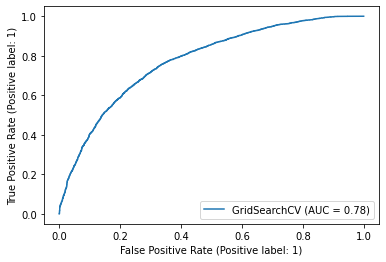

In [44]:
plot_roc_curve(grid_rf, X_ts, Y_ts)

#### [4.4]
#### XGBOOST

#### XGBoost Inputs

##### Description:

Creating a sklearn pipeline using the ColumnTransformer and the XGBoost and pass through all the variable

##### Parameters for Classifier: 

Max Depth of the tree:
    
    2, 10, 1

Number of estimators:
    
    60, 220, 40
    
Learning Rate: 
    
    0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.05
    
##### Inputs:

For the training of the data:
    X_resample and Y_resample:
        
##### Resampling of Data:

Why are we resampling the data?
    
    Before resampling the data, I tried creating a classifer which resulted in 96% accuracy although, bad class 1 accuracy. Hence we undersampled the data so that the classifier can properly identify the features and train it easily
        

In [45]:
XGB_pipe = Pipeline(
    steps = [("Transformer", ct), ("Classifier", XGBClassifier(verbosity = 0))])

In [46]:
sampler = RandomUnderSampler()
X_sample, Y_sample = sampler.fit_resample(X_dummies, Y)

In [56]:
params = {
    'Classifier__max_depth': range (2, 10, 1),
    'Classifier__n_estimators': range(60, 220, 40),
    'Classifier__learning_rate': [0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.05]
}

In [48]:
grid_xgb = GridSearchCV(XGB_pipe,
                      param_grid=params,
                      scoring = 'accuracy', 
                      cv = 5)

In [49]:
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X_sample, Y_sample, test_size = 0.4, random_state = 42, stratify=Y_sample)

In [50]:
grid_xgb.fit(X_tr, Y_tr)
pred = grid_xgb.predict(X_ts)

#### XGBOOST Outputs:

##### Metrics:

Precision of class 0, 1, and combined using the classification report

Recall of class 0, 1, and combined using the classification report

F-1 Score of class 0, 1, and combined using the classification report

Accuracy of the model using the classification report

##### Graphs:

Here we have a ROC-Curve that shows how well the model is being fitted to the data.


In [51]:
print(accuracy_score(pred, Y_ts))
print(confusion_matrix(pred, Y_ts))
print(classification_report(pred, Y_ts))

0.7075699617475337
[[3511 1449]
 [1456 3518]]
              precision    recall  f1-score   support

           0       0.71      0.71      0.71      4960
           1       0.71      0.71      0.71      4974

    accuracy                           0.71      9934
   macro avg       0.71      0.71      0.71      9934
weighted avg       0.71      0.71      0.71      9934



https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html

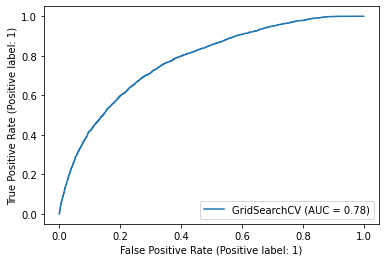

In [52]:
plot_roc_curve(grid_xgb, X_ts, Y_ts)

## [5] Final Thoughts and Conclusions:

#### [5.1]
#### Justification for using the models:

**Logistic Regression**: 

Using Logistic regression as an obvious choice because it is the most sought after model in the classification pipelines and problems. I wanted to see how the Logistic regression models performs well on an imbalanced dataset and it was not doing a good job on handling the data.

**Decision Tree:**

Decision Trees can handle imbalanced datasets pretty well and thus was my first pick. Although this did give a 97% accuracy, it was not doing a great job with the imbalance either. Hence that is where I thought I should definitely undersample class 0.

**Random Forest:**
    
This is a pretty popular method for handling data that might be slightly imbalanced data and was giving 89% accuracy, it had a good effect on the class 1 as compared to the Decision Tree and Logistic Regression.

**XGBoost:**
    
XGBoost outperforms every other classification model in my opinion. TreeBoosting algorithms have been great for classifying the imbalanced classes and do a great job when there is a balance in the data. 


**GridSearchCV:**
    
Using GridSearchCV for hyperparameter training as it will create the model best suited for the data.

#### [5.2] All the columns that were important:

##### Reason:
These columns produced very less correlations and they give an unbiased picture to all the models. 

In [61]:
X.columns.to_list()

['creditLimit',
 'availableMoney',
 'transactionAmount',
 'posEntryMode',
 'posConditionCode',
 'merchantCategoryCode',
 'transactionType',
 'currentBalance',
 'cardPresent',
 'expirationDateKeyInMatch',
 'CVV Match',
 'multiswipeMinutes',
 'FirstVendorPurchase',
 'sameCountry']

##### New Features:
    cvvMatch, FirstVendorPurchase, MultiswipeMinutes and sameCountry are the new features I created. 
    
Refer to 4.2, 5, 6.2, 6.3 of Question 3.ipynb for reference

#### [5.3] What would have I done with more time:

- I could have created another feature for the expiration Date which I couldn't get an idea of. 

- I would have used RandomisedSearch CV and compared with the Grid Search CV models.

- I could have Deep Learning models on the un-sampled trained data itself and see if I could have got a better accuracy.

- Compared all the ROC curves together as I was not able to figure out.

#### [5.4] What questions do I have:

- What kind of features do you usually look at, while doing Fraud Detection and how close are the results with the real life.

- What do you expect the final result of the machine learning/deep learning model be used at and how is the company going to use all the models?

- As much as this data is imbalanced, the real-life training data is going to be extremely imbalanced and how are you able to detect a Fraud going on in real-time?

- What is the best way to tackle this kind of imbalance data, especially at the firm?
